
# Why DGGS? Motivation

> “A Discrete Global Grid System (DGGS) is a spatial reference system that uses a hierarchical tessellation of cells to partition and address the globe.”  
> — OGC Abstract Specification, 2017 (OGC 15‑104r5: Topic 21)  
> Accessible at the Open Geospatial Consortium website  [oai_citation:0‡docs.ogc.org](https://docs.ogc.org/as/15-104r5/15-104r5.html?utm_source=chatgpt.com)



**Key properties of DGGS:**
- Equal Area
- Seamless Global Coverage
- Multi-Scale (hierarchical, supports multiple resolutions)

Traditional map projections introduce distortion:

<p align="center">
  <img src="https://raw.githubusercontent.com/EOPF-DGGS/LPS25_demo/refs/heads/main/images/latlon_dggs.png" alt="Classes of map projections" width="500">
</p>



---


# DGGS Families: Examples and Images

DGGS come in many types. Two of the most widely-used in Earth sciences are **H3** and **HEALPix**:

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td style="width:50%; padding:10px; vertical-align:top;">

### H3 (Uber)

- Hexagonal, hierarchical grid  
- Fast indexing and analysis  
- Used for urban and mobility studies  

<img src="https://raw.githubusercontent.com/EOPF-DGGS/LPS25_demo/refs/heads/main/images/H3.png" alt="H3 grid" width="200" style="border-radius:10px; box-shadow:0 2px 6px #ccc;">

</td>
<td style="width:50%; padding:10px; vertical-align:top;">

### HEALPix

- Equal-area, hierarchical grid  
- Seamless global coverage  
- Ideal for planetary-scale studies  

<img src="https://raw.githubusercontent.com/EOPF-DGGS/LPS25_demo/refs/heads/main/images/healpix0.png" alt="HEALPix grid" width="200" style="border-radius:10px; box-shadow:0 2px 6px #ccc;">

</td>
  </tr>
  <tr>
    <td colspan="2" style="padding-top:10px; font-size:90%;">

Both figures are from:  
Kmoch et al. (2024). *XDGGS: A community-developed Xarray package to support planetary DGGS data cube computations.* [doi:10.5194/isprs-archives-XLVIII-4-W12-2024-75-2024](https://doi.org/10.5194/isprs-archives-XLVIII-4-W12-2024-75-2024)

  </tr>
</table>

---

### Area Distortion Analysis

The figure below (also from Kmoch et al., 2024) summarizes normalized area values for various DGGS types, highlighting HEALPix's strong equal-area properties:

<img src="https://raw.githubusercontent.com/EOPF-DGGS/LPS25_demo/refs/heads/main/images/fig2.png" alt="Normalized area values for DGGS" width="400" style="display:block; margin:auto; border-radius:10px; box-shadow:0 2px 6px #ccc;">

---

**Further resources:**  
- [DGGS Expertise at University of Tartu](https://landscape-geoinformatics.ut.ee/expertise/dggs/)  
- [Awesome Discrete Global Grid Systems](https://github.com/LandscapeGeoinformatics/awesome-discrete-global-grid-systems)

## ✅ Getting Started: Interactive HEALPix Grid

Below is an interactive HEALPix grid visualization using Plotly and Healpy.

- Each dot represents the center of a HEALPix cell at refinement_level=3 (try changing `refinement_level` for more or fewer cells).
- Hover over points to see pixel numbers.
- The grid is equal-area and hierarchical, ideal for scalable geospatial analysis.

**You can edit and experiment with the code:**
- Increase `refinement_level` for higher resolution grids (finer detail).
- Decrease `refinement_level` for lower resolution grids (less detail).

For more information, see the [HEALPix documentation](https://healpix.sourceforge.io/).

In [1]:
import numpy as np
import healpy as hp
import plotly.graph_objects as go
import plotly.io as pio
import cartopy.io.shapereader as shpreader
from shapely.geometry import LineString, MultiLineString

pio.renderers.default = 'notebook'

def sph2cart(theta, phi):
    """Convert spherical to Cartesian coordinates."""
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

def add_coastlines(fig, line_color='gray', line_width=1):
    """Add coastlines to Plotly 3D globe from Cartopy's Natural Earth data."""
    reader = shpreader.natural_earth(resolution='110m', category='physical', name='coastline')
    geometries = shpreader.Reader(reader).geometries()

    for geom in geometries:
        lines = [geom] if isinstance(geom, LineString) else list(geom.geoms) if isinstance(geom, MultiLineString) else []
        for line in lines:
            coords = np.array(line.coords)
            if coords.shape[0] < 2:
                continue
            lons, lats = coords[:, 0], coords[:, 1]
            theta, phi = np.radians(90 - lats), np.radians(lons)
            x, y, z = sph2cart(theta, phi)
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='lines',
                line=dict(color=line_color, width=line_width),
                showlegend=False
            ))

def create_healpix_plot(refinement_level=3, show_labels=True, color='red'):
    nside = 2**refinement_level
    npix = hp.nside2npix(nside)

    fig = go.Figure()

    # Add globe surface
    u, v = np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    fig.add_trace(go.Surface(
        x=x, y=y, z=z,
        colorscale=[[0, 'rgb(80,80,80)'], [1, 'rgb(20,20,20)']],  
        opacity=1.0,
        showscale=False
    ))

    # Plot HEALPix cells
    for pix in range(npix):
        boundary = hp.boundaries(nside, pix, step=20, nest=True)
        xb, yb, zb = boundary
        fig.add_trace(go.Scatter3d(
            x=np.append(xb, xb[0]),
            y=np.append(yb, yb[0]),
            z=np.append(zb, zb[0]),
            mode='lines',
            line=dict(color=color, width=2),
            showlegend=False
        ))

        if show_labels:
            theta, phi = hp.pix2ang(nside, pix, nest=True)
            xc, yc, zc = sph2cart(theta, phi)
            fig.add_trace(go.Scatter3d(
                x=[xc], y=[yc], z=[zc],
                mode='text',
                text=[str(pix)],
                textfont=dict(size=10, color=color),
                showlegend=False
            ))

    # Add coastline outlines
    add_coastlines(fig, line_color='#00B5E2', line_width=2.5)

    fig.update_layout(
        title=f"HEALPix NESTED refinement_level={refinement_level} with Coastlines",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='data'
        ),
        scene_camera=dict(eye=dict(x=1.3, y=1.3, z=1.3)),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()

# Example: Plot with refinement_level=3 and labels
create_healpix_plot(refinement_level=1, show_labels=True, color='red')

## 🌐 HEALPix Grid: Parent-Child Connectivity

The figure below visually demonstrates the hierarchical structure of the HEALPix grid (**parent-child connectivity**). Different colors represent different refinement levels:

- **Refinement Level 1 (Parent grid)**: 🔵 Blue, thicker lines, labeled with pixel IDs.
- **Refinement Level 2 (Intermediate grid)**: 🔴 Red, medium lines, labeled with pixel IDs.
- **Refinement Level 3 (Child grid)**: 🟢 Green, fine dotted lines, unlabeled for clarity.

This color-coded structure helps highlight how each level nests within the previous, supporting scalable multi-resolution Earth Observation analysis.

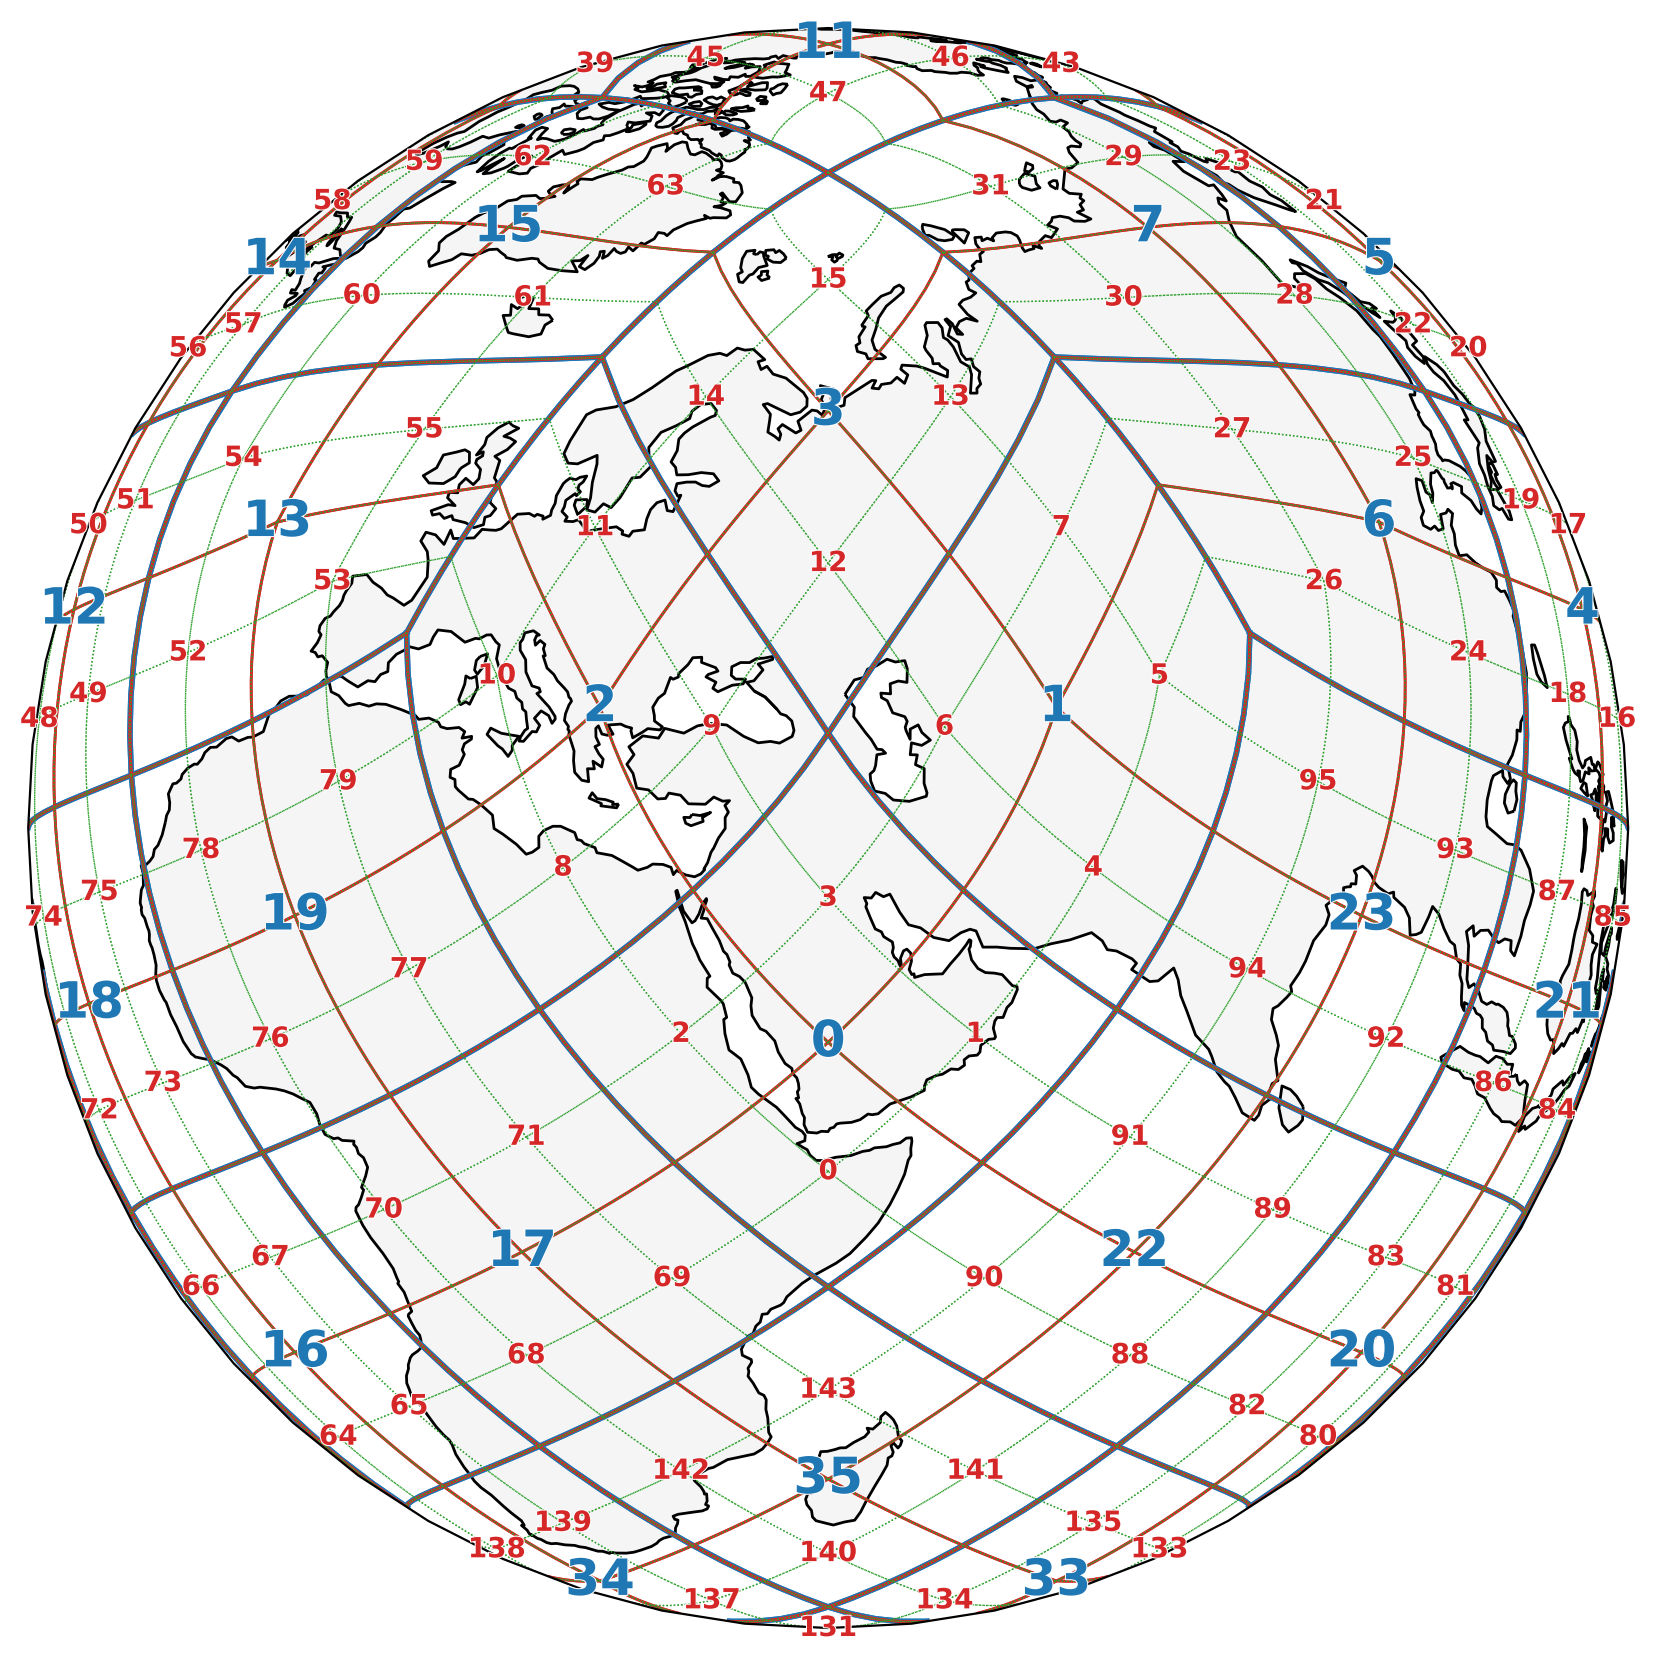

In [2]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import healpy as hp
import numpy as np
import matplotlib.patheffects as path_effects

def plot_healpix_grid(ax, refinement_level, color='black', linewidth=0.5, linestyle='-', 
                      show_ids=False, text_color='black', fontsize=10):
    """
    Plot HEALPix grid lines at a specified refinement level.
    """
    nside = 2 ** refinement_level
    npix = hp.nside2npix(nside)
    for pix in range(npix):
        boundary = hp.boundaries(nside, pix, step=10)
        lon, lat = hp.vec2ang(boundary.T, lonlat=True)
        lon = np.append(lon, lon[0])
        lat = np.append(lat, lat[0])
        ax.plot(lon, lat, transform=ccrs.Geodetic(),
                color=color, linewidth=linewidth, linestyle=linestyle)
        if show_ids:
            vec = hp.pix2vec(nside, pix,nest=True)
            vec = np.array(vec).T
            lon_c, lat_c = hp.vec2ang(vec, lonlat=True)
            ax.text(lon_c[0], lat_c[0], str(pix),
                    transform=ccrs.Geodetic(),
                    fontsize=fontsize,
                    weight='bold',  # Bold font for IDs
                    ha='center', va='center',
                    color=text_color,
                    path_effects=[
                        path_effects.Stroke(linewidth=0.75, foreground='white'),
                        path_effects.Normal()
                    ])

# Create figure and globe projection
fig = plt.figure(figsize=(8, 8), dpi=200)
projection = ccrs.Orthographic(central_longitude=45, central_latitude=35)
ax = plt.axes([0, 0, 1, 1], projection=projection)
ax.set_global()

# Earth features
ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.coastlines(resolution='110m')

# Plot: Blue (Level 1), Red (Level 2), Green (Level 3)
plot_healpix_grid(ax, refinement_level=1, color='#1f77b4', linewidth=2, linestyle='-',
                  show_ids=True, fontsize=18, text_color='#1f77b4')  # Blue, bold
plot_healpix_grid(ax, refinement_level=2, color='#d62728', linewidth=1.0, linestyle='-',
                  show_ids=True, fontsize=10, text_color='#d62728')  # Red
plot_healpix_grid(ax, refinement_level=3, color='#2ca02c', linewidth=0.5, linestyle=':',
                  show_ids=False)  # Green

plt.show()
plt.close()

## ✅ Summary

**Discrete Global Grid Systems (DGGS)** provide a powerful, scalable framework for Earth Observation and geospatial data analysis.

You learned:

- ✅ The **limitations of traditional map projections** for global-scale, multi-resolution applications (e.g., distortion, seams, lack of hierarchy)
- ✅ The DGGS and its essential properties:  
  **_Equal-area, seamless global coverage, hierarchical/multi-scale access_**
- ✅ DGGS examples:  
  - **H3 (hexagonal, hierarchical, efficient for mobility use cases)**  
  - **HEALPix (equal-area, iso-latitude, widely used in astronomy and Earth sciences)**  
  Including references and visuals for HEALPix.  
  - Understanding refinement levels (multi-resolution)
  - Exploring parent-child relationships and pixel IDs 

---

### 🔭 What's Next?

- 🧪 Try applying HEALPix to your own geospatial datasets  
- 🛠️ Explore additional DGGS tools: [XDGGS](https://github.com/xdggs/xdggs)
- 📚 Dive deeper with [Awesome DGGS](https://github.com/LandscapeGeoinformatics/awesome-discrete-global-grid-systems) and [Awesome HEALPix](https://github.com/pangeo-data/awesome-HEALPix) 

